In [1]:
#Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import math
import itertools
from scipy.stats import norm
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.stats import qmc
import scipy.special
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel
from sklearn.metrics import log_loss
from sklearn.linear_model import LinearRegression

from bo_methods_lib.bo_functions_generic import LHS_Design

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 5.1 Gaussian Process Prior

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


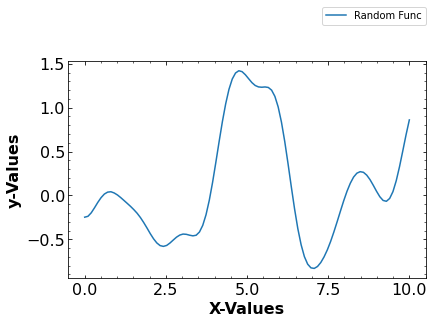

In [2]:
#Set number of experimental data/ set rng
np.random.seed(0) #Set seed
rng = np.random.default_rng() # sets up a "random" number generator
ndim= 1
nsamples = 100
eps = 1e-7
# eps = 0

#Define X data
# Xexp = np.random.rand(nsamples)*10 
Xexp = np.linspace(0,10,nsamples).reshape(-1,ndim)
# Yexp = np.sin(Xexp)
# print(Xexp.shape)

#Create a function for euclidean distance between 2 x-vector values
def kernel(x1,x2):
    vector_diff = x1-x2
    distance = np.exp(-np.linalg.norm(vector_diff)**2)
    return distance

#Define Covariance Matrix
cov = np.zeros((nsamples,nsamples))
#Loop over each sample
for i in range(nsamples):
    #Match with each sample
    for j in range(nsamples):
        x1 = Xexp[i]
        x2 = Xexp[j]
        cov[i,j] = kernel(x1,x2)

#Alternatively,
def covkernel(xi,xj,l=1.0):
    dij = cdist(xi,xj,metric='euclidean') # returns matrix of pairwise distances
    return np.exp(-1*dij**2/l)

cov2 = covkernel(Xexp,Xexp)
print(cov == cov2)

#Add jitter
cov += eps * np.eye(cov.shape[0])

#Set mean function (in this case 0)
mean=np.zeros(nsamples) # zero mean
# mean = np.ones(Xexp)*2 #Linear mean example

#Generate multivariate normal distribution
Y = rng.multivariate_normal(mean,cov)

#Plot data
plt.figure(figsize = (6.4,4))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(direction="in",top=True, right=True)
plt.locator_params(axis='y', nbins=5)
plt.locator_params(axis='x', nbins=5)
plt.minorticks_on() # turn on minor ticks
plt.tick_params(which="minor",direction="in",top=True, right=True)
#         plt.gca().axes.xaxis.set_ticklabels([]) # remove tick labels
#         plt.gca().axes.yaxis.set_ticklabels([])

#plot training data, testing data, and true values
plt.plot(Xexp, Y, label="Random Func")

#Set plot details
plt.legend(fontsize=10,bbox_to_anchor=(0, 1.05, 1, 0.2),borderaxespad=0)
#         plt.legend(loc = "best")
x_label = "X-Values"
y_label = "y-Values"
plt.xlabel(x_label, fontsize=16, fontweight='bold')
plt.ylabel(y_label, fontsize=16, fontweight='bold')
plt.show()

## 5.1.1 Gaussian Process Posterior

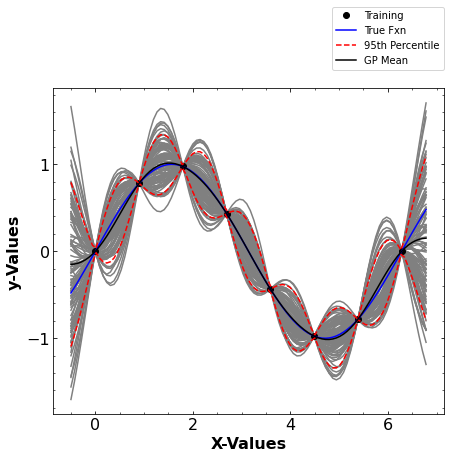

In [3]:
#Set number of experimental data/ set rng
np.random.seed(10) #Set seed
rng = np.random.default_rng() # sets up a "random" number generator
ndim= 1
nsamples = 8
nsamples_test = 100
eps = 1e-7

#Define X data
# Xexp = np.random.rand(nsamples)*10 
X = np.linspace(0,2*np.pi,nsamples)[:,np.newaxis]
Y = np.sin(X)

#Create a kernel function
def covkernel(xi,xj,l=1.0):
    dij = cdist(xi,xj,metric='euclidean') # returns matrix of pairwise distances
    return np.exp(-1*dij**2/l)

#Define Covariance matrix for Xexp training data and add jitter
Sigma = covkernel(X,X,l=1.0)
Sigma += eps * np.eye(Sigma.shape[0])

#Define Covariance Matrix for testing data set and add jitter
XX = np.linspace(-0.5,2*np.pi+0.5,nsamples_test)[:,np.newaxis]
SXX = covkernel(XX,XX,l=1.0)
SXX += eps * np.eye(SXX.shape[0])

#Define covariance between testing and training data and add jitter
#Note SX does not have jitter because it is not decomposed and isn't necessarily square
SX = covkernel(XX,X,l=1.0)

#Calculate posterior mean and variance
inv_Sig = np.linalg.inv(Sigma)
mup = SX@inv_Sig@Y
sigmap = SXX - SX@inv_Sig@SX.T
sdp = np.sqrt(np.diag(sigmap))

#Generate 100 predictions, YY for XX
YY = rng.multivariate_normal(mup[:,0], sigmap, nsamples_test)

#Calculate 5th and 95th percentiles for calculations
# sample_mean = np.mean(YY,axis=0)
# sample_stdev = np.std(YY, axis =0)
# q1   = sample_mean + 1*sample_stdev
# q2  = sample_mean - 1*sample_stdev
q1 = mup[:,0] + norm.ppf(0.05, loc=0, scale=sdp)
q2 = mup[:,0] + norm.ppf(0.95, loc=0, scale=sdp)

#Plot Posterior distribution
plt.figure(figsize = (7,6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(direction="in",top=True, right=True)
plt.locator_params(axis='y', nbins=7)
plt.locator_params(axis='x', nbins=5)
plt.minorticks_on() # turn on minor ticks
plt.tick_params(which="minor",direction="in",top=True, right=True)
plt.plot(XX[:,0], YY.T, color = "grey")
plt.plot(X[:,0], Y[:,0], marker = 'o',color='k', label = "Training", linestyle = "None")
plt.plot(XX[:,0], np.sin(XX), color = "blue", label = "True Fxn")
plt.plot(XX[:,0], q1,  linestyle='dashed', color = "red", label = "95th Percentile")
plt.plot(XX[:,0], q2,  linestyle='dashed', color = "red")
plt.plot(XX[:,0], mup[:,0], color = "black", label = "GP Mean")

#Set plot details
plt.legend(fontsize=10,bbox_to_anchor=(0, 1.05, 1, 0.2),borderaxespad=0)
x_label = "X-Values"
y_label = "y-Values"
plt.xlabel(x_label, fontsize=16, fontweight='bold')
plt.ylabel(y_label, fontsize=16, fontweight='bold')
plt.show()

## 5.1.2 Higher Dimensions

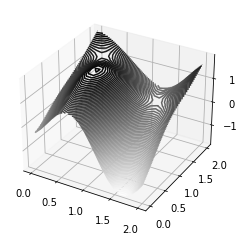

In [4]:
#In higher dimensions
#Set number of experimental data/ set rng
np.random.seed() #Set seed
rng = np.random.default_rng() # sets up a "random" number generator
ndim = 2
nx = 20
eps = 1e-14

#Define 2D X data
x = np.linspace(0,2,nx)
X = np.array(list(itertools.product(x, repeat=ndim)))

#Create a kernel function
def covkernel(xi,xj,l=1.0):
    dij = cdist(xi,xj,metric='euclidean') # returns matrix of pairwise distances
    return np.exp(-1*dij**2/l)

#Define Covariance matrix for Xexp training data and add jitter
Sigma = covkernel(X,X,l=1.0)
Sigma += eps * np.eye(Sigma.shape[0])

#Set mean function (in this case 0)
mean=np.zeros(nx**ndim) # zero mean

#Generate multivariate normal distribution
Y = rng.multivariate_normal(mean,Sigma)

fig = plt.figure()
ax = plt.axes(projection='3d')
# Data for a three-dimensional line
ax.contour3D(x, x, Y.reshape(nx,nx), 100, cmap='binary')

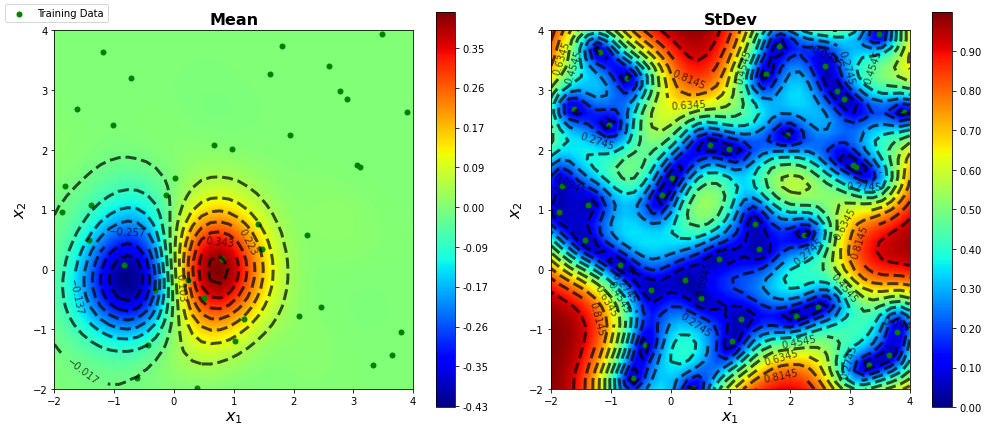

In [5]:
#Set number of experimental data/ set rng
np.random.seed(10) #Set seed
rng = np.random.default_rng() # sets up a "random" number generator
ndim= 2
nsamples = 40
eps = 1e-14

#Generate X data from LHS
X = LHS_Design(nsamples, ndim, seed = 10)
#Modify X data to correct scale
X[:,0] = (X[:,0] - 0.5)*6 +1
X[:,1] = (X[:,1] - 0.5)*6 +1

#Generate y data
y = X[:,0]*np.exp(-X[:,0]**2 -X[:,1]**2)


xx = np.linspace(-2,4,nsamples)
XX_mesh = np.array(np.meshgrid(xx,xx))
XX = XX_mesh.reshape((2,nsamples**2)).T

#Create Covariance Matrix for X
#Create a kernel function
def covkernel(xi,xj,l=1.0):
    dij = cdist(xi,xj,metric='euclidean') # returns matrix of pairwise distances
    return np.exp(-1*dij**2/l)

#Define Covariance matrix for Xexp training data and add jitter
Sigma = covkernel(X,X,l=1.0)
Sigma += eps * np.eye(Sigma.shape[0])

#Define Covariance Matrix for testing data set and add jitter
SXX = covkernel(XX,XX,l=1.0)
SXX += eps * np.eye(SXX.shape[0])

#Define covariance between testing and training data and add jitter
#Note SX does not have jitter because it is not decomposed and isn't necessarily square
SX = covkernel(XX,X,l=1.0)

#Calculate posterior mean and variance
inv_Sig = np.linalg.inv(Sigma)
mup = SX@inv_Sig@y
sigmap = SXX - SX@inv_Sig@SX.T
sdp = np.sqrt(np.diag(sigmap))

#Plot
X1, X2 = XX_mesh
Z1 = mup.reshape(nsamples,nsamples)
Z2 = sdp.reshape(nsamples,nsamples)
z = [Z1,Z2]
tot_lev = [60,60]
#Set plot details for mean predictions
fig, axes = plt.subplots(nrows = 1, ncols = len(z), figsize = (14,6))
ax = axes
title = ["Mean", "StDev"]

for i in range(len(z)):      
    #Create a colormap and colorbar for each subplot
    cs_fig = ax[i].contourf(X1, X2,z[i], levels = 900, cmap = "jet")
    if np.amax(z[i]) < 1e-1 or np.amax(z[i]) > 1000:
        cbar = plt.colorbar(cs_fig, ax = ax[i], format='%.2e')
    else:
        cbar = plt.colorbar(cs_fig, ax = ax[i], format = '%2.2f')

    #Create a line contour for each colormap
    cs2_fig = ax[i].contour(cs_fig, levels=cs_fig.levels[::tot_lev[i]], colors='k', alpha=0.7, linestyles='dashed', linewidths=3)
    ax[i].clabel(cs2_fig,  levels=cs_fig.levels[::tot_lev[i]][1::2], fontsize=10, inline=1)

    #plot training data X values
    ax[i].scatter(X[:,0],X[:,1], color="green",s=25, label = "Training Data", marker = "o")  

    #Get legend information
    if i == len(z)-1:
        handles, labels = ax[i].get_legend_handles_labels()

    #Plots axes such that they are scaled the same way (eg. circles look like circles) and name axes
    ax[i].axis('scaled')  
    ax[i].set_xlabel('$x_1$',weight='bold',fontsize=16)
    ax[i].set_ylabel('$x_2$',weight='bold',fontsize=16)

    #Plot title and set axis scale
    ax[i].set_title(title[i], weight='bold',fontsize=16)
    ax[i].set_xlim(left = np.amin(X1), right = np.amax(X1))
    ax[i].set_ylim(bottom = np.amin(X2), top = np.amax(X2))      

#Plots legend and title
plt.tight_layout()
fig.legend(handles, labels, loc="upper left")  #bbox_to_anchor=(-0.01, 0.9), borderaxespad=0
plt.show()

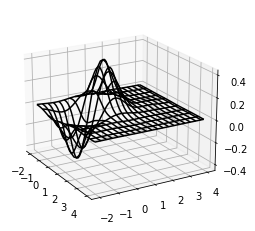

In [6]:
fig = plt.figure()
ax = plt.axes(projection='3d')
# Data for a three-dimensional line
ax.plot_wireframe(X1, X2, Z1.T, rstride=2, cstride=4, color = "black")
ax.view_init(20, -30)
plt.show()

# Section 5.2 GP Hyperparameters
## Section 5.2.1 Scale

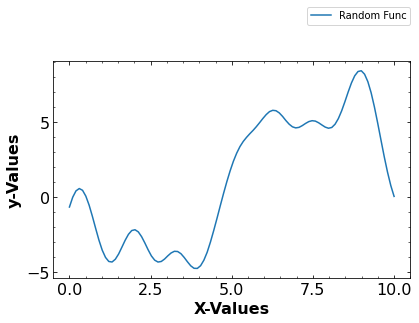

In [7]:
#Set number of experimental data/ set rng
np.random.seed(0) #Set seed
rng = np.random.default_rng() # sets up a "random" number generator
ndim= 1 #Number of dimensions
nsamples = 100 #Number of samples
eps = 1e-7 #Jitter factor
tau_2 = 25 #scale parameter
# eps = 0

#Define X data
Xexp = np.linspace(0,10,nsamples).reshape(-1,ndim)

#Define covariance matrix
Sigma = covkernel(Xexp,Xexp,l=1.0)

#Add jitter
cov += eps * np.eye(cov.shape[0])

#Set mean function (in this case 0)
mean=np.zeros(nsamples) # zero mean

#Generate multivariate normal distribution
Y = rng.multivariate_normal(mean,cov*tau_2)

#Plot data
plt.figure(figsize = (6.4,4))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(direction="in",top=True, right=True)
plt.locator_params(axis='y', nbins=5)
plt.locator_params(axis='x', nbins=5)
plt.minorticks_on() # turn on minor ticks
plt.tick_params(which="minor",direction="in",top=True, right=True)
#         plt.gca().axes.xaxis.set_ticklabels([]) # remove tick labels
#         plt.gca().axes.yaxis.set_ticklabels([])

#plot training data, testing data, and true values
plt.plot(Xexp, Y.T, label="Random Func")

#Set plot details
plt.legend(fontsize=10,bbox_to_anchor=(0, 1.05, 1, 0.2),borderaxespad=0)
#         plt.legend(loc = "best")
x_label = "X-Values"
y_label = "y-Values"
plt.xlabel(x_label, fontsize=16, fontweight='bold')
plt.ylabel(y_label, fontsize=16, fontweight='bold')
plt.show()

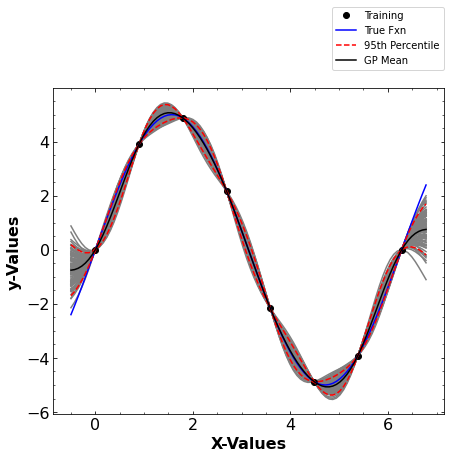

In [8]:
#Create a higher amplitude sine function example
#Set number of experimental data/ set rng
np.random.seed(0) #Set seed
rng = np.random.default_rng() # sets up a "random" number generator
ndim= 1
nsamples = 8
eps = 1e-7

#Define X data
X = np.linspace(0,2*np.pi,nsamples).reshape(-1,ndim)
XX = np.linspace(-0.5,2*np.pi+0.5,100).reshape(-1,ndim)
Y = 5*np.sin(X)

#Define Covariance matrix for Xexp training data and add jitter
Sigma = covkernel(X,X,l=1.0)
# Sigma += eps * np.eye(Sigma.shape[0])

#Define Covariance Matrix for testing data set and add jitter
SXX = covkernel(XX,XX,l=1.0)
SXX += eps * np.eye(SXX.shape[0])

#Define covariance between testing and training data and add jitter
#Note SX does not have jitter because it is not decomposed and isn't necessarily square
SX = covkernel(XX,X,l=1.0)

#Calculate posterior mean and variance
inv_Sig = np.linalg.inv(Sigma)
mup = SX@inv_Sig@Y
sigmap = SXX - SX@inv_Sig@SX.T
sdp = np.sqrt(np.diag(sigmap))

#Generate 100 predictions, YY for XX
YY = rng.multivariate_normal(mup[:,0], sigmap, nsamples_test)

#Calculate 5th and 95th percentiles for calculations
# sample_mean = np.mean(YY,axis=0)
# sample_stdev = np.std(YY, axis =0)
# q1   = sample_mean + 1*sample_stdev
# q2  = sample_mean - 1*sample_stdev
q1 = mup[:,0] + norm.ppf(0.05, loc=0, scale=sdp)
q2 = mup[:,0] + norm.ppf(0.95, loc=0, scale=sdp)

#Plot Posterior distribution
plt.figure(figsize = (7,6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(direction="in",top=True, right=True)
plt.locator_params(axis='y', nbins=7)
plt.locator_params(axis='x', nbins=5)
plt.minorticks_on() # turn on minor ticks
plt.tick_params(which="minor",direction="in",top=True, right=True)
plt.plot(XX[:,0], YY.T, color = "grey")
plt.plot(X[:,0], Y[:,0], marker = 'o',color='k', label = "Training", linestyle = "None")
plt.plot(XX[:,0], 5*np.sin(XX), color = "blue", label = "True Fxn")
plt.plot(XX[:,0], q1,  linestyle='dashed', color = "red", label = "95th Percentile")
plt.plot(XX[:,0], q2,  linestyle='dashed', color = "red")
plt.plot(XX[:,0], mup[:,0], color = "black", label = "GP Mean")

#Set plot details
plt.legend(fontsize=10,bbox_to_anchor=(0, 1.05, 1, 0.2),borderaxespad=0)
x_label = "X-Values"
y_label = "y-Values"
plt.xlabel(x_label, fontsize=16, fontweight='bold')
plt.ylabel(y_label, fontsize=16, fontweight='bold')
plt.show()

2*sqrt(tau_2_hat):  5.486647915782523


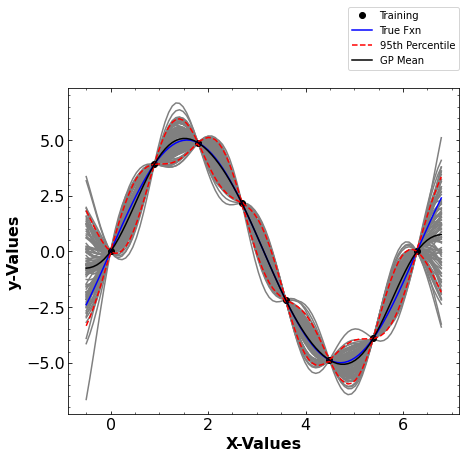

In [9]:
#Add scaling factor to approximation above and repeat
#Define covariance matricies which will be scaled by scaling factor tau
CX = SX
Ci = inv_Sig
CXX= SXX
tau_2_hat = Y.T@Ci@Y/len(Y)
tau_2_hat = tau_2_hat.squeeze()
print("2*sqrt(tau_2_hat): ", 2*np.sqrt(tau_2_hat))

#Calculate posterior mean and variance
mup2 = CX@Ci@Y
sigmap2 = tau_2_hat*(CXX - CX@Ci@CX.T)
sdp2 = np.sqrt(np.diag(sigmap2))

#Generate 100 predictions, YY for XX
YY = rng.multivariate_normal(mup2[:,0], sigmap2, nsamples_test)

#Calculate 5th and 95th percentiles for calculations
# sample_mean = np.mean(YY,axis=0)
# sample_stdev = np.std(YY, axis =0)
# q1   = sample_mean + 1*sample_stdev
# q2  = sample_mean - 1*sample_stdev
q1 = mup2[:,0] + norm.ppf(0.05, loc=0, scale=sdp2)
q2 = mup2[:,0] + norm.ppf(0.95, loc=0, scale=sdp2)

#Plot Posterior distribution
plt.figure(figsize = (7,6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(direction="in",top=True, right=True)
plt.locator_params(axis='y', nbins=7)
plt.locator_params(axis='x', nbins=5)
plt.minorticks_on() # turn on minor ticks
plt.tick_params(which="minor",direction="in",top=True, right=True)
plt.plot(XX[:,0], YY.T, color = "grey")
plt.plot(X[:,0], Y[:,0], marker = 'o',color='k', label = "Training", linestyle = "None")
plt.plot(XX[:,0], 5*np.sin(XX), color = "blue", label = "True Fxn")
plt.plot(XX[:,0], q1,  linestyle='dashed', color = "red", label = "95th Percentile")
plt.plot(XX[:,0], q2,  linestyle='dashed', color = "red")
plt.plot(XX[:,0], mup2[:,0], color = "black", label = "GP Mean")

#Set plot details
plt.legend(fontsize=10,bbox_to_anchor=(0, 1.05, 1, 0.2),borderaxespad=0)
x_label = "X-Values"
y_label = "y-Values"
plt.xlabel(x_label, fontsize=16, fontweight='bold')
plt.ylabel(y_label, fontsize=16, fontweight='bold')
plt.show()

In [10]:
#Define function to calculate score
def score(Y, mu, Sigma, mah=False):
    Ymmu = Y - mu
    Sigmai = np.linalg.inv(Sigma)
    mahdist = Ymmu.T@Sigmai@Ymmu
    if mah:
        return np.sqrt(mahdist)
    else:
        sign, logdet = np.linalg.slogdet(Sigma)
        return -logdet - mahdist
#         return -np.log(np.linalg.det(Sigma)) - mahdist   

In [11]:
#Define scores using scaling factor of 1 and optimized scaling factor
Ytrue = 5*np.sin(XX)
mah = True
scores = np.array([score(Ytrue, mup, sigmap, mah=mah), score(Ytrue, mup2, sigmap2, mah=mah)]).squeeze()
df = pd.DataFrame(np.array([scores]), columns = ["tau2=1", "tau2_hat"])
print(df)

     tau2=1  tau2_hat
0  6.080483  2.216466


## 5.2.2 Noise and Nuggets

In [12]:
#Define negative likelihood of nugget g as a function
def nlg(g, X, Y):
    n = len(Y)
    K = covkernel(X,X,l=1.0)
    Kjit = K + g * np.eye(K.shape[0])
    Ki = np.linalg.inv(Kjit)
    sign, logdet = np.linalg.slogdet(Kjit)
    ldetK = logdet
    ll = -(n/2)*np.log(Y.T@Ki@Y) - (1/2)*ldetK
    return -ll

In [13]:
#Optimize g
np.random.seed(8) #Set seed
rng = np.random.default_rng() # sets up a "random" number generator

eps = 1e-7 #Jitter factor
Xnew = np.concatenate((X,X)) #Define 2 repeats of X (because we are adding noise)
n = Xnew.shape[0] #Define number of samples
Ynew = 5*np.sin(Xnew) + np.random.normal(size=(n,1)  ,loc = 0, scale = 1) #Define Y data
bnds = np.array([eps, np.var(Ynew)]).reshape(1,-1) #Set bounds on g between jitter and variance of Y
#optimize g
solution = scipy.optimize.minimize(nlg, 1, args = (Xnew,Ynew), method='L-BFGS-B', bounds=bnds, tol=1e-10 )
print(solution)
g = solution.x
iterations = solution.nit
g = g.flatten()
print("Value of g: ", g)
print("# of Iterations: ", iterations)

      fun: 36.41682945188904
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 20
      nit: 4
     njev: 10
   status: 0
  success: True
        x: array([0.27909762])
Value of g:  [0.27909762]
# of Iterations:  4


In [14]:
#Define covariance matrix and optimize scaling factor tau2hat
K = covkernel(Xnew,Xnew,l=1.0)
K += g * np.eye(K.shape[0])
Ki = np.linalg.inv(K)
tau2hat = Ynew.T@Ki@Ynew/n
tau2hat = tau2hat.flatten()
print("tau: ", np.sqrt(tau2hat))
print("sigma: ", np.sqrt(tau2hat*g))

tau:  [2.8391373]
sigma:  [1.49990744]


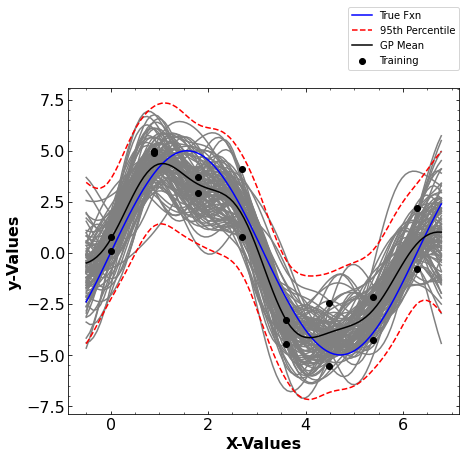

In [15]:
#Define Covariance matricies
KX = covkernel(XX,Xnew,l=1.0)
KXX = covkernel(XX,XX,l=1.0)
KXX += g * np.eye(KXX.shape[0])

#Calculate covariance matrix and GP mean
mup = KX@Ki@Ynew
sigmap = tau2hat*(KXX - KX@Ki@KX.T)
sdp = np.sqrt(np.diag(sigmap))

#Calculate 5th and 95th percentiles for calculations
q1 = mup[:,0] + norm.ppf(0.05, loc=0, scale=sdp)
q2 = mup[:,0] + norm.ppf(0.95, loc=0, scale=sdp)

#Define covariance matrix that uses eps instead of a nugget to add jitter
KXX2 = covkernel(XX,XX,l=1.0)
KXX2 += eps * np.eye(KXX.shape[0])
sigma_int = tau2hat*(KXX2 - KX@Ki@KX.T)

# #Generate 100 predictions, YY for XX using the eps based covariance predictions
YY = rng.multivariate_normal(mup[:,0], sigma_int, nsamples_test)

# #Plot Posterior distribution
plt.figure(figsize = (7,6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(direction="in",top=True, right=True)
plt.locator_params(axis='y', nbins=7)
plt.locator_params(axis='x', nbins=5)
plt.minorticks_on() # turn on minor ticks
plt.tick_params(which="minor",direction="in",top=True, right=True)
plt.plot(XX[:,0], YY.T, color = "grey")
plt.plot(XX[:,0], 5*np.sin(XX), color = "blue", label = "True Fxn")
plt.plot(XX[:,0], q1,  linestyle='dashed', color = "red", label = "95th Percentile")
plt.plot(XX[:,0], q2,  linestyle='dashed', color = "red")
plt.plot(XX[:,0], mup[:,0], color = "black", label = "GP Mean")
plt.scatter(Xnew[:,0], Ynew[:,0], marker = 'o',color='k', label = "Training", linestyle = "None", zorder =3)

#Set plot details
plt.legend(fontsize=10,bbox_to_anchor=(0, 1.05, 1, 0.2),borderaxespad=0)
x_label = "X-Values"
y_label = "y-Values"
plt.xlabel(x_label, fontsize=16, fontweight='bold')
plt.ylabel(y_label, fontsize=16, fontweight='bold')
plt.show()

## 5.2.3 Derivative-Based Hyperparameter Optimization

In [16]:
#Define the gradient of the negative likelihood w.r.t nugget g
def gnlg(g, X, Y):
    n = len(Y)
    K = covkernel(X,X,l=1.0)
    Kjit = K + g * np.eye(K.shape[0])
    Ki = np.linalg.inv(Kjit)
    KiY = Ki@Y
    dll = (n/2)*KiY.T@KiY/(Y.T@KiY)-(1/2)*np.sum(np.diag(Ki))
    return -1*dll

In [17]:
#Optimize parameter g using the gradient
#Note. I'm not sure how to recreate what the example is doing in python. I don't think this is right
bnds = np.array([eps, np.var(Ynew)]).reshape(1,-1)
solution = scipy.optimize.minimize(nlg, 0.1, args = (Xnew,Ynew), method='L-BFGS-B', jac= gnlg, bounds=bnds, tol=1e-10 )
print(solution)
g = solution.x
g = g.flatten()
iterations = solution.nit
print("Val nugget g: ", g)
print("# of Iterations: ", iterations)

      fun: 36.41682945188901
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([[2.78131125e-07]])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 12
      nit: 6
     njev: 12
   status: 0
  success: True
        x: array([0.27909758])
Val nugget g:  [0.27909758]
# of Iterations:  6


## 5.2.4 Lengthscale: rate decay of correlation

In [18]:
#Create a kernel function
def covkernel(xi,xj,l=1.0):
    dij = cdist(xi,xj,metric='euclidean') # returns matrix of pairwise distances
    return np.exp(-(1*dij**2)/l)

#Define negative lieklihood function w.r.t g and \ell
def nl(par, X, Y):
    ell, g = par
    n = len(Y)
    K = covkernel(X,X,l=ell)
    Kjit = K + g * np.eye(K.shape[0])
    Ki = np.linalg.inv(Kjit)
    sign, logdet = np.linalg.slogdet(Kjit)
    ldetK = logdet
    ll = -(n/2)*np.log(Y.T@Ki@Y) - (1/2)*ldetK
    return -ll

In [19]:
#Define LHS sample
#Generate X data from LHS
nsamples =40
ndim =2
X = LHS_Design(nsamples, ndim, seed = 10)
X2 = np.concatenate((X,X)) #Define 2 repeats of X (because we are adding noise)

#Modify X data to correct scale
X2[:,0] = (X2[:,0] - 0.5)*6 +1
X2[:,1] = (X2[:,1] - 0.5)*6 +1

#Generate y data
np.random.seed(2) #Set seed
Y2 = X2[:,0]*np.exp(-X2[:,0]**2 -X2[:,1]**2) + np.random.normal(size=(len(X2))  ,loc = 0, scale = 0.01) #Define Y data

In [20]:
bnds = np.array([[eps, 10], #Set bounds on \ell between jitter and 10
                [eps, np.var(Y2)]])#Set bounds on g between jitter and variance of Y
#optimize \ell and g
init = np.array([1, 0.1*np.var(Y2)])
solution = scipy.optimize.minimize(nl, init, args = (X2,Y2), method='L-BFGS-B', bounds=bnds, tol=1e-10 )
print(solution)
ell, g = solution.x
iterations = solution.nit
ell = ell.flatten()
g = g.flatten()
print("Value of g: ", g)
print("Value of \ell: ", ell)
print("# of Iterations: ", iterations)

      fun: -104.36694434159008
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00014779,  0.00220695])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 39
      nit: 10
     njev: 13
   status: 0
  success: True
        x: array([1.06668234, 0.00614352])
Value of g:  [0.00614352]
Value of \ell:  [1.06668234]
# of Iterations:  10


In [21]:
#Define gradient of nl w.r.t g and \ell #Need AD check if error
def gradnl(par, X, Y):
    #Separate parameters
    ell, g = par
    #Calculate covariance quantities
    n = len(Y)
    K = covkernel(X,X,l=ell)
    Kjit = K + g * np.eye(K.shape[0])
    Ki = np.linalg.inv(Kjit)
    D = cdist(X,X,metric='euclidean')
    dotK = Kjit*D/ell**2
    KiY = Ki@Y
    dlltheta = (n/2)*KiY.T@dotK@KiY/(Y.T@KiY) - (1/2)*np.sum(np.diag(Ki@dotK))
    dllg = (n/2) * KiY.T@KiY /(Y.T@KiY) - (1/2)*np.sum(np.diag(Ki))
    grad = -np.array([dlltheta, dllg])
    return grad

In [22]:
np.random.seed(2) #Set seed
bnds = np.array([[eps, 10], #Set bounds on \ell between jitter and 10
                [eps, np.var(Y2)]])#Set bounds on g between jitter and variance of Y
#optimize \ell and g
init = np.array([0.1, 0.1*np.var(Y2)])
solution = scipy.optimize.minimize(nl, init, args = (X2,Y2), method='L-BFGS-B', jac = gradnl, bounds=bnds, tol=1e-10 )
print(solution)
ell, g = solution.x
iterations = solution.nit
ell_opt = ell.flatten()
g_opt = g.flatten()
print("Value of g: ", g)
print("Value of \ell: ", ell)
print("# of Iterations: ", iterations)

      fun: -104.36299911953715
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-19.10847146,  28.39407188])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 57
      nit: 5
     njev: 57
   status: 2
  success: False
        x: array([1.07920204, 0.00618449])
Value of g:  0.006184491485054337
Value of \ell:  1.0792020422886943
# of Iterations:  5


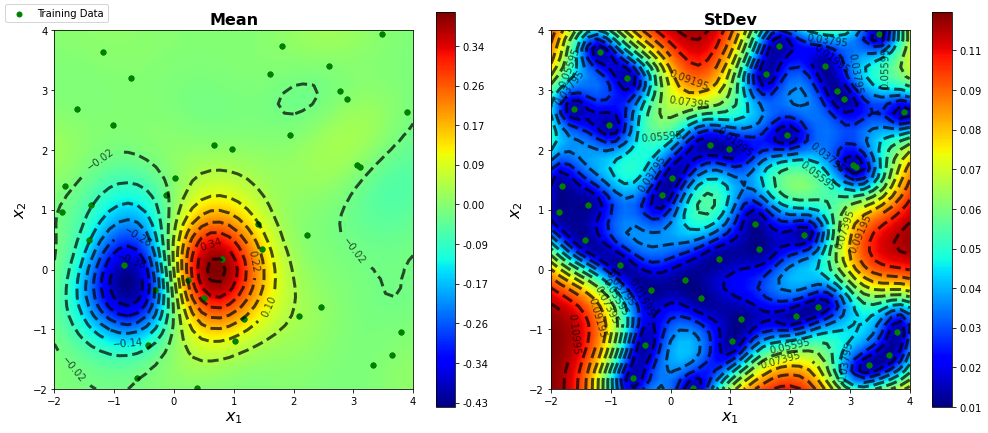

In [23]:
#Build training quantities
K = covkernel(X2,X2,l=ell_opt)
K += g_opt * np.eye(K.shape[0])
Ki = np.linalg.inv(K)
tau2hat = Y2.T@Ki@Y2/(X2.shape[0])


#Build predictive quantities
gn =40
#Define meshgrid for plotting 
xx = np.linspace(-2,4,gn)
XX_mesh = np.array(np.meshgrid(xx,xx))
XX = XX_mesh.reshape((2,gn**2)).T

KXX = covkernel(XX,XX,l=ell_opt) 
KXX += g_opt * np.eye(KXX.shape[0])

KX = covkernel(XX,X2,l=ell_opt)

#Add kriging equations
mup = KX@Ki@Y2
Sigmap = tau2hat*(KXX-KX@Ki@KX.T)
sdp = np.sqrt(np.diag(Sigmap))

#Plot
Xa, Xb = XX_mesh
Z1 = mup.reshape(gn,gn)
Z2 = sdp.reshape(gn,gn)
z = [Z1,Z2]
tot_lev = [60,60]
#Set plot details for mean predictions
fig, axes = plt.subplots(nrows = 1, ncols = len(z), figsize = (14,6))
ax = axes
title = ["Mean", "StDev"]

for i in range(len(z)):      
    #Create a colormap and colorbar for each subplot
    cs_fig = ax[i].contourf(Xa, Xb,z[i], levels = 900, cmap = "jet")
    if np.amax(z[i]) < 1e-1 or np.amax(z[i]) > 1000:
        cbar = plt.colorbar(cs_fig, ax = ax[i], format='%.2e')
    else:
        cbar = plt.colorbar(cs_fig, ax = ax[i], format = '%2.2f')

    #Create a line contour for each colormap
    cs2_fig = ax[i].contour(cs_fig, levels=cs_fig.levels[::tot_lev[i]], colors='k', alpha=0.7, linestyles='dashed', linewidths=3)
    ax[i].clabel(cs2_fig,  levels=cs_fig.levels[::tot_lev[i]][1::2], fontsize=10, inline=1)

    #plot training data X values
    ax[i].scatter(X2[:,0],X2[:,1], color="green",s=25, label = "Training Data", marker = "o")  

    #Get legend information
    if i == len(z)-1:
        handles, labels = ax[i].get_legend_handles_labels()

    #Plots axes such that they are scaled the same way (eg. circles look like circles) and name axes
    ax[i].axis('scaled')  
    ax[i].set_xlabel('$x_1$',weight='bold',fontsize=16)
    ax[i].set_ylabel('$x_2$',weight='bold',fontsize=16)

    #Plot title and set axis scale
    ax[i].set_title(title[i], weight='bold',fontsize=16)
    ax[i].set_xlim(left = np.amin(Xa), right = np.amax(Xa))
    ax[i].set_ylim(bottom = np.amin(Xb), top = np.amax(Xb))      

#Plots legend and title
plt.tight_layout()
fig.legend(handles, labels, loc="upper left")  #bbox_to_anchor=(-0.01, 0.9), borderaxespad=0
plt.show()

## 5.2.5 Anisotropic Modeling

In [24]:
def fried(n=50, m = 6):
    assert m>5, "Must have at least 5 columns"
    X = LHS_Design(n, m, seed = 10)
    Ytrue = 10*np.sin(np.pi*X[:,0]*X[:,1]) + 20*(X[:,2] -0.5)**2 + 10*X[:,3] + 5*X[:,4]
    Y = Ytrue + np.random.normal(size=(Ytrue.size)  ,loc = 0, scale = 1)
    Y = Y.reshape(-1,1)
    Ytrue = Ytrue.reshape(-1,1)
    stack = np.hstack((X, Y, Ytrue))
    dataframe = pd.DataFrame(data = stack)
    return dataframe

In [25]:
m = 7
n = 200
nprime = 1000

data = fried(n+nprime, m)
X = data.to_numpy()[0:n,0:m]
Y = data.to_numpy()[0:n,m:m+1].flatten()
XX = data.to_numpy()[n:nprime, 0:m]
YY = data.to_numpy()[n:nprime,-2].flatten()
YYtrue = data.to_numpy()[n:nprime,-1].flatten()

np.random.seed(6) #Set seed
bnds = np.array([[eps, 10], #Set bounds on \ell between jitter and 10
                [eps, np.var(Y)]])#Set bounds on g between jitter and variance of Y
#optimize \ell and g
init = np.array([1, 0.1*np.var(Y)])
solution = scipy.optimize.minimize(nl, init, args = (X,Y), method='L-BFGS-B', jac = gradnl, bounds=bnds, tol=1e-10 )
print(solution)
ell, g = solution.x
iterations = solution.nit
ell_opt = ell.flatten()
g_opt = g.flatten()
print("Value of g: ", g)
print("Value of \ell: ", ell)
print("# of Iterations: ", iterations)

      fun: 675.5663979822878
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.27576475, -3.87894376])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 59
      nit: 7
     njev: 59
   status: 0
  success: True
        x: array([6.14289264e+00, 4.31546751e-03])
Value of g:  0.004315467512974555
Value of \ell:  6.14289263515841
# of Iterations:  7


In [26]:
#Build training quantities
K = covkernel(X,X,l=ell_opt)
K += g_opt * np.eye(K.shape[0])
Ki = np.linalg.inv(K)
tau2hat = Y.T@Ki@Y/(X.shape[0])

KXX = covkernel(XX,XX,l=ell_opt) 
KXX += g_opt * np.eye(KXX.shape[0])

KX = covkernel(XX,X,l=ell_opt)

#Add kriging equations
mup = KX@Ki@Y
Sigmap = tau2hat*(KXX-KX@Ki@KX.T)
sdp = np.sqrt(np.diag(Sigmap))

#Calculate RMSE
rmse = np.sqrt(np.average((YYtrue - mup)**2))
print("gpiso: ", round(rmse,3))

#Note skipping MARS implementation because I can't find an install package for python that works with Python 3.10

gpiso:  1.463


In [27]:
def covkernel_sep(xi,xj,l):
    dij2_l_sum = 0
    for i in range(xi.shape[1]):
        xi1 = xi[:,i].reshape(-1,1)
        xj1 = xj[:,i].reshape(-1,1)
        dij = cdist(xi1,xj1,metric='euclidean')
        dij2_l_sum +=  dij**2/l[i]# returns matrix of pairwise distances
        
    return np.exp(-dij2_l_sum)

def nlsep(par, X, Y):
    theta = par[0:X.shape[1]]
    g = par[-1]
    n = Y.shape[0]
    K = covkernel_sep(X, X, theta)
    K += g * np.eye(K.shape[0])
    Ki = np.linalg.inv(K)
    sign, logdet = np.linalg.slogdet(K)
    ldetK = logdet
    ll = -(n/2)*np.log(Y.T@Ki@Y) - (1/2)*ldetK
    return -ll
    

In [28]:
%time
np.random.seed(6) #Set seed
ell_bounds = np.array([eps, 10])
l_bounds = np.tile(ell_bounds,(X.shape[1],1))
g_bounds = np.array([eps, np.var(Y)]).reshape(-1,2)
bnds = np.concatenate((l_bounds, g_bounds), axis=0)

#optimize \ell and g
hp_guess = np.ones((X.shape[1]))*0.1
init = np.append(hp_guess, 0.1*np.var(Y))
solution = scipy.optimize.minimize(nlsep, init, args = (X,Y), method='L-BFGS-B', bounds=bnds, tol=1e-10 )
print(solution)
hps = solution.x
ell = hps[0:-1]
g = hps[-1]
iterations = solution.nit
ell_opt = ell.flatten()
g_opt = g.flatten()
print("Value of g: ", g)
print("Value of \ell: ", ell)
print("# of Iterations: ", iterations)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs
      fun: 640.0006811670646
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0058435 ,  0.00495675,  0.00159162, -0.00699174, -0.30677254,
       -0.45986322, -0.50913509,  0.00846967])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 441
      nit: 28
     njev: 49
   status: 0
  success: True
        x: array([ 1.38583732,  1.3419457 ,  1.86638644,  8.63764515, 10.        ,
       10.        , 10.        ,  0.01102145])
Value of g:  0.011021449423706616
Value of \ell:  [ 1.38583732  1.3419457   1.86638644  8.63764515 10.         10.
 10.        ]
# of Iterations:  28


In [29]:
def gradnlsep(par, X, Y): #Need AD to check this
    theta = par[0:X.shape[1]]
    g = par[-1]
    n = Y.shape[0]
    K = covkernel_sep(X, X, theta)
    K += g * np.eye(K.shape[0])
    Ki = np.linalg.inv(K)
    KiY = Ki@Y
    
    #loop over theta components
    dlltheta = np.zeros((len(theta)))
    for k in range(len(theta)):
        xi1 = X[:,k].reshape(-1,1)
        xj1 = X[:,k].reshape(-1,1)
        dij = cdist(xi1,xj1,metric='euclidean')
        dotK = K * dij/theta[k]**2
        dlltheta[k] = (n/2)*KiY.T@dotK@KiY /(Y.T@KiY) - (1/2)*np.sum(np.diag(Ki@dotK))
        
    #for g
    dllg = (n/2)*KiY.T@KiY/(Y.T@KiY) - (1/2)*np.sum(np.diag(Ki))
    dllg_mat = np.array([dllg]).reshape(1,-1)
    grad = -np.append(dlltheta, dllg_mat)
    return grad

In [30]:
%time
np.random.seed(6) #Set seed
ell_bounds = np.array([eps, 10])
l_bounds = np.tile(ell_bounds,(X.shape[1],1))
g_bounds = np.array([eps, np.var(Y)]).reshape(-1,2)
bnds = np.concatenate((l_bounds, g_bounds), axis=0)

#optimize \ell and g
hp_guess = np.ones((X.shape[1]))*1
init = np.append(hp_guess, 0.1*np.var(Y))
solution = scipy.optimize.minimize(nlsep, init, args = (X,Y), method='L-BFGS-B', jac = gradnlsep, bounds=bnds, tol=1e-10 )
print(solution)
hps = solution.x
ell = hps[0:-1]
g = hps[-1]
iterations = solution.nit
ell_opt = ell.flatten()
g_opt = g.flatten()
print("Value of g: ", g)
print("Value of \ell: ", ell)
print("# of Iterations: ", iterations)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.77 µs
      fun: 655.6497176777826
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 37.82431711, 159.71635141,  65.67561708,  -1.65902502,
        -0.82038573,   1.09198826,  -3.7935586 ,   5.64201237])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 182
      nit: 16
     njev: 182
   status: 2
  success: False
        x: array([1.25655492, 1.27277831, 0.47506577, 6.08890569, 6.90384079,
       6.36588973, 7.06573433, 0.01992432])
Value of g:  0.01992431850943723
Value of \ell:  [1.25655492 1.27277831 0.47506577 6.08890569 6.90384079 6.36588973
 7.06573433]
# of Iterations:  16


In [31]:
#Build training quantities
K = covkernel_sep(X, X, ell_opt)
K += g_opt * np.eye(K.shape[0])
Ki = np.linalg.inv(K)
tau2hat = Y.T@Ki@Y/(X.shape[0])

KXX = covkernel_sep(XX, XX, ell_opt)
KXX += g_opt * np.eye(KXX.shape[0])

KX = covkernel_sep(XX, X, ell_opt)

#Add kriging equations
mup2 = KX@Ki@Y
Sigmap2 = tau2hat*(KXX-KX@Ki@KX.T)
sdp2 = np.sqrt(np.diag(Sigmap2))

#Calculate RMSE
rmse2 = np.sqrt(np.average((YYtrue - mup2)**2))
print("gpiso: ", round(rmse,3))
print("gpsep: ", round(rmse2,3))

gpiso:  1.463
gpsep:  1.003


In [32]:
print("gpiso score: ", score(YY, mup, Sigmap))
print("gpsep score: ", score(YY, mup2, Sigmap2))
print(YY.shape, mup.shape, Sigmap.shape)

gpiso score:  -1327.5583249658248
gpsep score:  -1042.6942381892652
(800,) (800,) (800, 800)


## 5.2.6 Library

In [33]:
#Apply scikit learn library
%time
#Define kernel with g and vector theta
kernel = ConstantKernel(constant_value=1, constant_value_bounds=(1e-4, 1e-2))*RBF(length_scale = np.ones(X.shape[1]), length_scale_bounds=(1e-2, 1e2))
#Define and fit the model
gpr = GaussianProcessRegressor(kernel=kernel, random_state=1, n_restarts_optimizer =1, optimizer = "fmin_l_bfgs_b")
fit_process = gpr.fit(X, Y)
#Back out trained hps
opt_kern_params = fit_process.kernel_
outputscl_final = opt_kern_params.k1.constant_value
lenscl_final = opt_kern_params.k2.length_scale

#Print hps
print("g: ", outputscl_final)
print("\ell: ", lenscl_final)

#Find rmse values and prediction values
results = gpr.predict(XX, return_cov=True)

mup3 = results[0]
Sigmap3 = results[1]

print("RMSE: ",np.sqrt(np.average((YYtrue - mup3)**2)))
print("scikit learn score: ", score(YY, mup3, Sigmap3))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 7.63 µs
g:  0.010000000000000004
\ell:  [0.40983325 0.43729733 0.23421474 0.35738863 0.40023858 1.23725322
 1.18361811]
RMSE:  2.3685176656526106
scikit learn score:  -8139257.377187653


/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


## 5.2.7 A bakeoff

In [34]:
import time
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

R = 30 #30 MC iterations
scores = np.zeros((3,R,3)) #Methods x MC iters x RMSE, score, time
#loop over R
for r in range(R):
    #Train-test partition and application of f(x) on both
    data = fried(2*n, m)
    train = data.to_numpy()[:n,:]
    test = data.to_numpy()[n:2*n,:]
    
    #Extract elements from training and testing set
    X = train[:,:m]
    Y = train[:,-2].flatten()
    XX = test[:,:m]
    YY = test[:,-2].flatten()
    YYtrue = test[:,-1].flatten()
    
    #Isotropic GP fit and predict by hand
    tic = time.process_time()
    bnds = np.array([[eps, 10], #Set bounds on \ell between jitter and 10
                [eps, np.var(Y)]])#Set bounds on g between jitter and variance of Y
    init = np.array([0.1, 0.1*np.var(Y)])
    solution = scipy.optimize.minimize(nl, init, args = (X,Y), method='L-BFGS-B', jac = gradnl, bounds=bnds, tol=1e-10 )
    ell, g = solution.x
    iterations = solution.nit
    ell_opt_iso = ell.flatten()
    g_opt_iso = g.flatten()
    K = covkernel(X,X,l=ell_opt_iso)
    K += g_opt_iso * np.eye(K.shape[0])
    Ki = np.linalg.inv(K)
    tau2hat = Y.T@Ki@Y/(X.shape[0])
    KXX = covkernel(XX,XX,l=ell_opt_iso) 
    KXX += g_opt_iso * np.eye(KXX.shape[0])
    KX = covkernel(XX,X,l=ell_opt_iso) 
    mup = KX@Ki@Y
    Sigmap = tau2hat*(KXX-KX@Ki@KX.T)
    toc = time.process_time() 
    
    #Isotropic GP fit and predict by hand
    scores[0, r, 0] = np.sqrt(np.average((YYtrue - mup)**2))
    scores[0, r, 1] = score(YY, mup, Sigmap)
    scores[0, r, 2] = toc - tic
    
    #Seperable GP fit and predict by hand
    tic = time.process_time()
    ell_bounds = np.array([eps, 10])
    l_bounds = np.tile(ell_bounds,(X.shape[1],1))
    g_bounds = np.array([eps, np.var(Y)]).reshape(-1,2)
    bnds = np.concatenate((l_bounds, g_bounds), axis=0)
    hp_guess = np.ones((X.shape[1]))*1
    init = np.append(hp_guess, 0.1*np.var(Y))
    solution = scipy.optimize.minimize(nlsep, init, args = (X,Y), method='L-BFGS-B', jac = gradnlsep, bounds=bnds, tol=1e-10 )
    hps = solution.x
    ell = hps[0:-1]
    g = hps[-1]
    iterations = solution.nit
    ell_opt_sep = ell.flatten()
    g_opt_sep = g.flatten()
    K = covkernel_sep(X,X,ell_opt_sep)
    K += g_opt_sep * np.eye(K.shape[0])
    Ki = np.linalg.inv(K)
    tau2hat = Y.T@Ki@Y/(X.shape[0])
    KXX = covkernel_sep(XX,XX,ell_opt_sep) 
    KXX += g_opt_sep * np.eye(KXX.shape[0])
    KX = covkernel_sep(XX,X,ell_opt_sep)
    mup2 = KX@Ki@Y
    Sigmap2 = tau2hat*(KXX-KX@Ki@KX.T)
    toc = time.process_time()
    
    #Calculation of metrics for seperable GP by hand
    scores[1, r, 0] = np.sqrt(np.average((YYtrue - mup2)**2))
    scores[1, r, 1] = score(YY, mup2, Sigmap2)
    scores[1, r, 2] = toc - tic
    
    #Scikit learn based seperable GP
    tic = time.process_time()
    kernel = ConstantKernel(constant_value=0.008, constant_value_bounds=(1e-4, 1e-2))*RBF(length_scale = np.ones(X.shape[1]), length_scale_bounds=(1e-2, 1e2))
    gpr = GaussianProcessRegressor(kernel=kernel, random_state=1, n_restarts_optimizer =1, optimizer = "fmin_l_bfgs_b")
    fit_process = gpr.fit(X, Y)
    opt_kern_params = fit_process.kernel_
    g_opt_skl = opt_kern_params.k1.constant_value
    ell_opt_skl = opt_kern_params.k2.length_scale
    results = gpr.predict(XX, return_cov=True)
    mup3 = results[0]
    Sigmap3 = results[1]
    toc = time.process_time()
    
    #Calculation of metrics for scikit learn GP by hand
    scores[2, r, 0] = np.sqrt(np.average((YYtrue - mup2)**2))
    scores[2, r, 1] = score(YY, mup2, Sigmap2)
    scores[2, r, 2] = toc - tic    

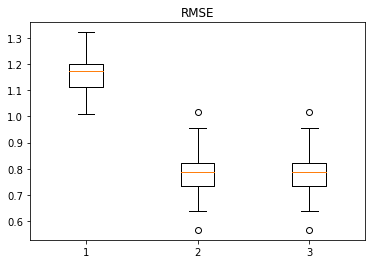

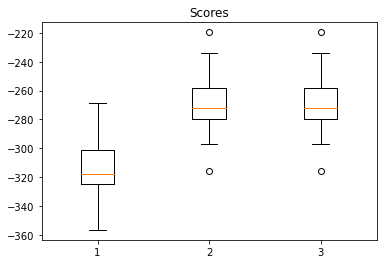

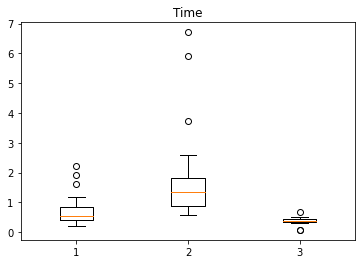

In [35]:
#Create boxplots of data
data1 = scores[:,:,0]
fig1, ax1 = plt.subplots()
ax1.set_title('RMSE')
ax1.boxplot(data1.T)

data2 = scores[:,:,1]
fig2, ax2 = plt.subplots()
ax2.set_title('Scores')
ax2.boxplot(data2.T)

data3 = scores[:,:,2]
fig3, ax3 = plt.subplots()
ax3.set_title('Time')
ax3.boxplot(data3.T)
plt.show()

#1 = isotropic, 2 = seperable, 3 = scikit learn

# 5.3 Some interpretation and perspective

## 5.3.3 Stationary Kernels

In [36]:
#Define matern kernel
def matern(r, nu, theta):
    rat = r*np.sqrt(2*nu/theta)
    C = ((2**(1-nu))/scipy.special.gamma(nu))*(rat**nu)*scipy.special.kv(nu, rat)
    C[np.isnan(C)] = 1
    return C

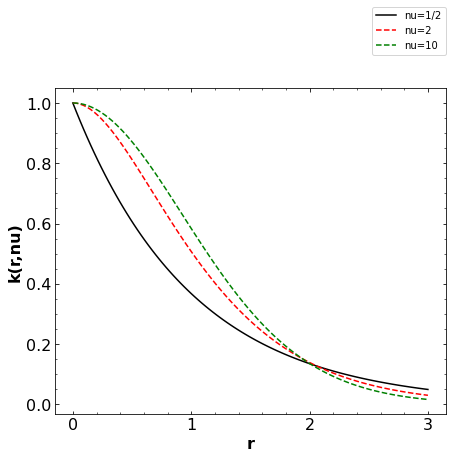

In [37]:
r = np.linspace(eps,3,100)

# #Plot Matern functions w/ different nus
plt.figure(figsize = (7,6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(direction="in",top=True, right=True)
plt.locator_params(axis='y', nbins=7)
plt.locator_params(axis='x', nbins=5)
plt.minorticks_on() # turn on minor ticks
plt.tick_params(which="minor",direction="in",top=True, right=True)
plt.plot(r, matern(r, 0.5, 1), color = "black", label = "nu=1/2")
plt.plot(r, matern(r, 2, 1),  linestyle='dashed', color = "red", label = "nu=2")
plt.plot(r, matern(r, 10, 1),  linestyle='dashed', color = "green", label = "nu=10")

#Set plot details
plt.legend(fontsize=10,bbox_to_anchor=(0, 1.05, 1, 0.2),borderaxespad=0)
x_label = "r"
y_label = "k(r,nu)"
plt.xlabel(x_label, fontsize=16, fontweight='bold')
plt.ylabel(y_label, fontsize=16, fontweight='bold')
plt.show()

In [38]:
X = np.linspace(eps,10,100).reshape(-1,1)
R = cdist(X,X,metric='euclidean')
K_05 = matern(R, 0.5, 1)
K_2 = matern(R, 2, 1)
K_10 = matern(R, 10, 1)
mean = np.zeros((len(X)))

p_05 = rng.multivariate_normal(mean, K_05, 3)
p_2 = rng.multivariate_normal(mean, K_2, 3)
p_10 = rng.multivariate_normal(mean, K_10, 3)
to_plot = [p_05.T, p_2.T, p_10.T]

/tmp/ipykernel_4187819/2338211909.py:4: RuntimeWarning: invalid value encountered in multiply
  C = ((2**(1-nu))/scipy.special.gamma(nu))*(rat**nu)*scipy.special.kv(nu, rat)


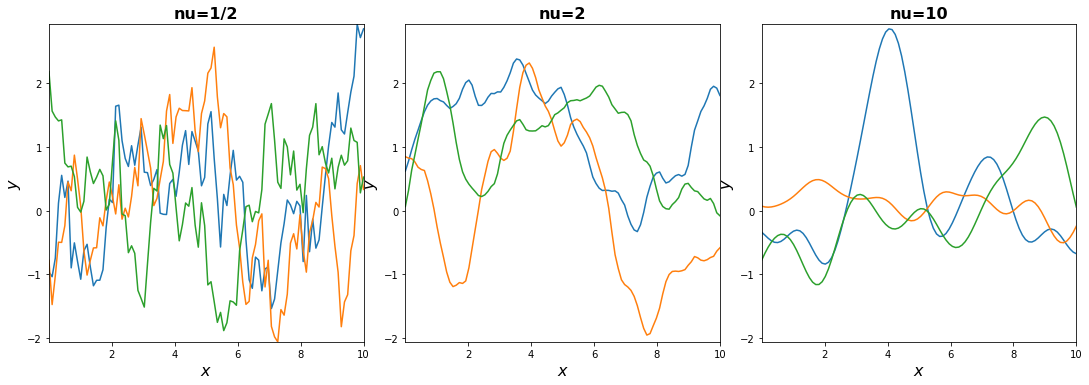

In [39]:
#Set plot details for mean predictions
title = ["nu=1/2", "nu=2", "nu=10"]

fig, ax = plt.subplots(nrows = 1, ncols = len(to_plot), figsize = (15,5))
#Plots legend and title
plt.tight_layout()

for i in range(len(to_plot)):
#Get legend information
    ax[i].plot(X, to_plot[i])
#     if i == len(to_plot)-1:
#         handles, labels = ax[i].get_legend_handles_labels()

    #Plots axes such that they are scaled the same way (eg. circles look like circles) and name axes  
    ax[i].set_xlabel('$x$',weight='bold',fontsize=16)
    ax[i].set_ylabel('$y$',weight='bold',fontsize=16)

    #Plot title and set axis scale
    ax[i].set_title(title[i], weight='bold',fontsize=16)
    ax[i].set_xlim(left = np.amin(X), right = np.amax(X))
    ax[i].set_ylim(bottom = np.amin(to_plot), top = np.amax(to_plot)) 
#     ax[i].axis('square')

# fig.legend(handles, labels, loc="upper left")  #bbox_to_anchor=(-0.01, 0.9), borderaxespad=0
plt.show()

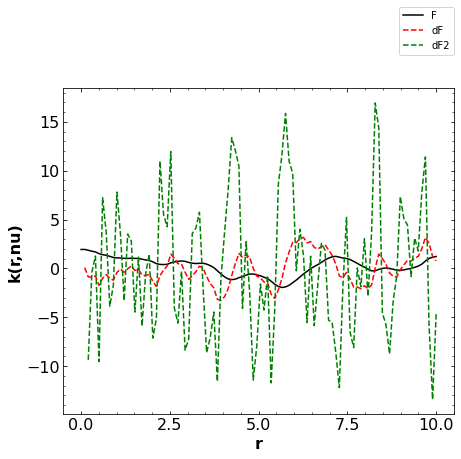

In [40]:
F = rng.multivariate_normal(mean, K_2, 1).T.reshape(-1,1)
dF = (F[1:] - F[:len(F)-1])/(X[1] - X[0])
dF2 = (dF[1:] - dF[:len(dF)-1])/(X[1] - X[0])

# #Plot Matern functions w/ different nus
plt.figure(figsize = (7,6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(direction="in",top=True, right=True)
plt.locator_params(axis='y', nbins=7)
plt.locator_params(axis='x', nbins=5)
plt.minorticks_on() # turn on minor ticks
plt.tick_params(which="minor",direction="in",top=True, right=True)
plt.plot(X, F, color = "black", label = "F")
plt.plot(X[1:], dF,  linestyle='dashed', color = "red", label = "dF")
plt.plot(X[2:],dF2,  linestyle='dashed', color = "green", label = "dF2")

#Set plot details
plt.legend(fontsize=10,bbox_to_anchor=(0, 1.05, 1, 0.2),borderaxespad=0)
x_label = "r"
y_label = "k(r,nu)"
plt.xlabel(x_label, fontsize=16, fontweight='bold')
plt.ylabel(y_label, fontsize=16, fontweight='bold')
plt.show()

In [41]:
def powerexp(r, alpha, theta):
    C = np.exp(-(r/np.sqrt(theta))**(alpha))
    C[np.isnan(C)] = 1
    return C

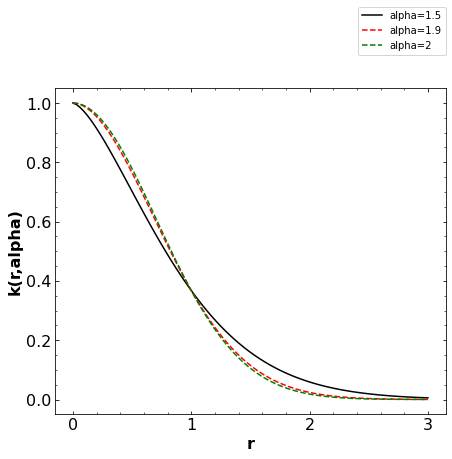

In [42]:
r = np.linspace(eps,3,100)

# #Plot Matern functions w/ different nus
plt.figure(figsize = (7,6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(direction="in",top=True, right=True)
plt.locator_params(axis='y', nbins=7)
plt.locator_params(axis='x', nbins=5)
plt.minorticks_on() # turn on minor ticks
plt.tick_params(which="minor",direction="in",top=True, right=True)
plt.plot(r, powerexp(r, 1.5, 1), color = "black", label = "alpha=1.5")
plt.plot(r, powerexp(r, 1.9, 1),  linestyle='dashed', color = "red", label = "alpha=1.9")
plt.plot(r, powerexp(r, 2, 1),  linestyle='dashed', color = "green", label = "alpha=2")

#Set plot details
plt.legend(fontsize=10,bbox_to_anchor=(0, 1.05, 1, 0.2),borderaxespad=0)
x_label = "r"
y_label = "k(r,alpha)"
plt.xlabel(x_label, fontsize=16, fontweight='bold')
plt.ylabel(y_label, fontsize=16, fontweight='bold')
plt.show()

In [43]:
Ka_15 = powerexp(R, 1.5, 1)
Ka_19 = powerexp(R, 1.9, 1)
Ka_20 = powerexp(R, 2, 1)

pa_15 = rng.multivariate_normal(mean, Ka_15, 3)
pa_19 = rng.multivariate_normal(mean, Ka_19, 3)
pa_20 = rng.multivariate_normal(mean, Ka_20, 3)
to_plot = [pa_15.T, pa_19.T, pa_20.T]

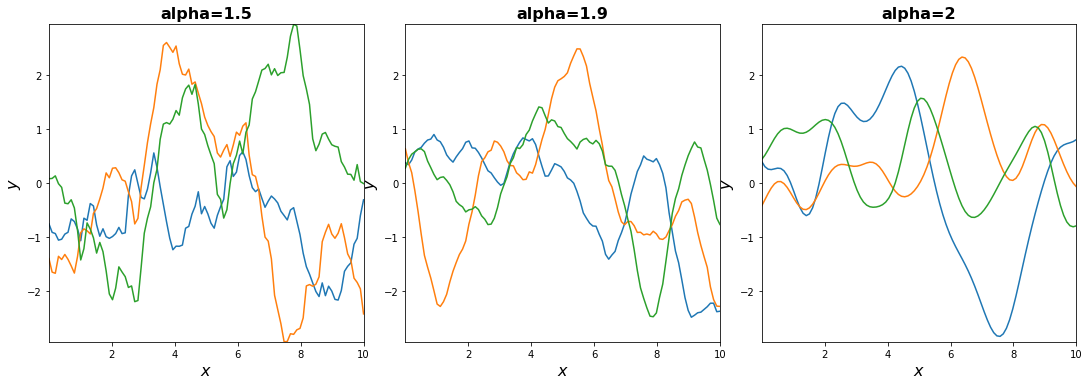

In [44]:
#Set plot details for mean predictions
title = ["alpha=1.5", "alpha=1.9", "alpha=2"]

fig, ax = plt.subplots(nrows = 1, ncols = len(to_plot), figsize = (15,5))
#Plots legend and title
plt.tight_layout()

for i in range(len(to_plot)):
#Get legend information
    ax[i].plot(X, to_plot[i])
#     if i == len(to_plot)-1:
#         handles, labels = ax[i].get_legend_handles_labels()

    #Plots axes such that they are scaled the same way (eg. circles look like circles) and name axes  
    ax[i].set_xlabel('$x$',weight='bold',fontsize=16)
    ax[i].set_ylabel('$y$',weight='bold',fontsize=16)

    #Plot title and set axis scale
    ax[i].set_title(title[i], weight='bold',fontsize=16)
    ax[i].set_xlim(left = np.amin(X), right = np.amax(X))
    ax[i].set_ylim(bottom = np.amin(to_plot), top = np.amax(to_plot)) 
#     ax[i].axis('square')

# fig.legend(handles, labels, loc="upper left")  #bbox_to_anchor=(-0.01, 0.9), borderaxespad=0
plt.show()

In [45]:
def ratquad(r, alpha, theta):
    C = (1 + r**2/(2*alpha*theta))**(-alpha)
    C[np.isnan(C)] = 1
    return C

Krq_05 = ratquad(R, 1/2, 1)
Krq_2 = ratquad(R, 2, 1)
Krq_10 = ratquad(R, 10, 1)

prq_05 = rng.multivariate_normal(mean, Krq_05, 3)
prq_2 = rng.multivariate_normal(mean, Krq_2, 3)
prq_10 = rng.multivariate_normal(mean, Krq_10, 3)
to_plot = [prq_05.T, prq_2.T, prq_10.T]

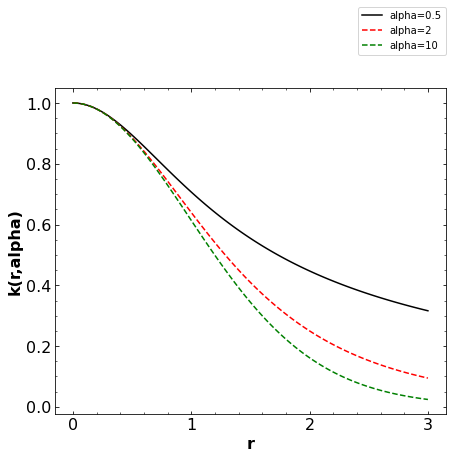

In [46]:
r = np.linspace(eps,3,100)

# #Plot Matern functions w/ different nus
plt.figure(figsize = (7,6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(direction="in",top=True, right=True)
plt.locator_params(axis='y', nbins=7)
plt.locator_params(axis='x', nbins=5)
plt.minorticks_on() # turn on minor ticks
plt.tick_params(which="minor",direction="in",top=True, right=True)
plt.plot(r, ratquad(r, 0.5, 1), color = "black", label = "alpha=0.5")
plt.plot(r, ratquad(r, 2, 1),  linestyle='dashed', color = "red", label = "alpha=2")
plt.plot(r, ratquad(r, 10, 1),  linestyle='dashed', color = "green", label = "alpha=10")

#Set plot details
plt.legend(fontsize=10,bbox_to_anchor=(0, 1.05, 1, 0.2),borderaxespad=0)
x_label = "r"
y_label = "k(r,alpha)"
plt.xlabel(x_label, fontsize=16, fontweight='bold')
plt.ylabel(y_label, fontsize=16, fontweight='bold')
plt.show()

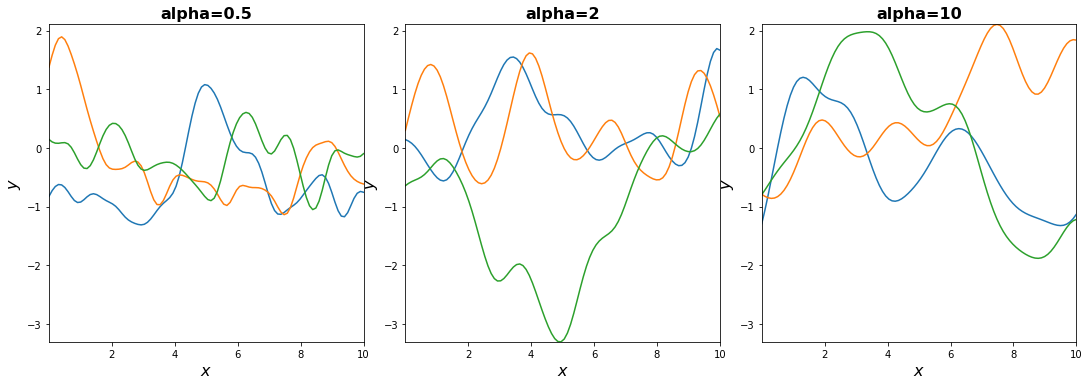

In [47]:
#Set plot details for mean predictions
title = ["alpha=0.5", "alpha=2", "alpha=10"]

fig, ax = plt.subplots(nrows = 1, ncols = len(to_plot), figsize = (15,5))
#Plots legend and title
plt.tight_layout()

for i in range(len(to_plot)):
#Get legend information
    ax[i].plot(X, to_plot[i])
#     if i == len(to_plot)-1:
#         handles, labels = ax[i].get_legend_handles_labels()

    #Plots axes such that they are scaled the same way (eg. circles look like circles) and name axes  
    ax[i].set_xlabel('$x$',weight='bold',fontsize=16)
    ax[i].set_ylabel('$y$',weight='bold',fontsize=16)

    #Plot title and set axis scale
    ax[i].set_title(title[i], weight='bold',fontsize=16)
    ax[i].set_xlim(left = np.amin(X), right = np.amax(X))
    ax[i].set_ylim(bottom = np.amin(to_plot), top = np.amax(to_plot)) 
#     ax[i].axis('square')

# fig.legend(handles, labels, loc="upper left")  #bbox_to_anchor=(-0.01, 0.9), borderaxespad=0
plt.show()

## 5.3.4 Signal to noise

In [48]:
X = np.linspace(0,10,40).reshape(-1,1)
ytrue = np.sin((np.pi*X/5)) + 0.2*np.cos(4*np.pi*X/5)
y = ytrue + np.random.normal(size=(ytrue.size)  ,loc = 0, scale = 0.2).reshape(-1,1)
g = np.linspace(0.001, 0.4, 100)
theta = np.linspace(0.1,4,100)
grid = np.array(np.meshgrid(g,theta)).T.reshape(-1,2)
ll =np.zeros((len(grid)))
xx = np.linspace(0,10,100).reshape(-1,1)
pm = np.zeros((len(grid),len(xx)))
psd = np.zeros((len(grid),len(xx)))
for i in range(len(grid)):
    kernel = ConstantKernel(constant_value=grid[i,0], constant_value_bounds="fixed")*RBF(length_scale = grid[i,1], length_scale_bounds="fixed")
    gpr = GaussianProcessRegressor(kernel=kernel, random_state=1, n_restarts_optimizer =1, optimizer = None)
    fit_process = gpr.fit(X, y)
    results = gpr.predict(xx, return_std=True)
    ll[i] = gpr.log_marginal_likelihood() #This is wrong.
    pm[i] = results[0]
    psd[i] = results[1]
l = np.exp(ll - np.max(ll))

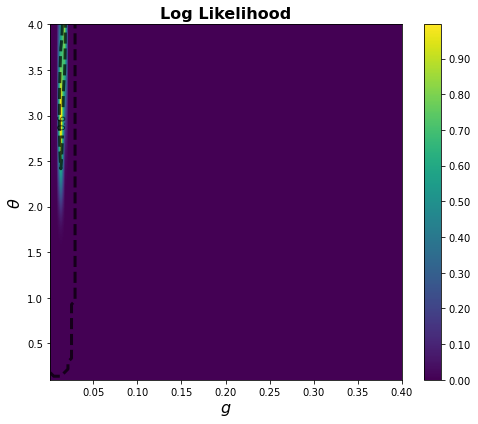

In [49]:
#Plot
l_mesh = l.reshape(len(g),len(theta))
z = [l_mesh]
tot_lev = [400]
#Set plot details for mean predictions
fig, axes = plt.subplots(nrows = 1, ncols = len(z), figsize = (7,6))
ax = axes
title = ["Log Likelihood"]

#Create a colormap and colorbar for each subplot
cs_fig = ax.contourf(g, theta, z[0], levels = 900, cmap = "viridis")
if np.amax(z[0]) < 1e-1 or np.amax(z[0]) > 1000:
    cbar = plt.colorbar(cs_fig, ax = ax, format='%.2e')
else:
    cbar = plt.colorbar(cs_fig, ax = ax, format = '%2.2f')

#Create a line contour for each colormap
cs2_fig = ax.contour(cs_fig, levels=cs_fig.levels[::tot_lev[0]], colors='k', alpha=0.7, linestyles='dashed', linewidths=3)
ax.clabel(cs2_fig,  levels=cs_fig.levels[::tot_lev[0]][1::2], fontsize=10, inline=1)

#Get legend information
# if i == len(z)-1:
#     handles, labels = ax.get_legend_handles_labels()

#Plots axes such that they are scaled the same way (eg. circles look like circles) and name axes
# ax.axis('square')  
ax.set_ylabel('$\\theta$',weight='bold',fontsize=16)
ax.set_xlabel('$g$',weight='bold',fontsize=16)

#Plot title and set axis scale
ax.set_title(title[0], weight='bold',fontsize=16)
ax.set_xlim(left = np.amin(g), right = np.amax(g))
ax.set_ylim(bottom = np.amin(theta), top = np.amax(theta))      

#Plots legend and title
plt.tight_layout()
# fig.legend(handles, labels, loc="upper left")  #bbox_to_anchor=(-0.01, 0.9), borderaxespad=0
plt.show()

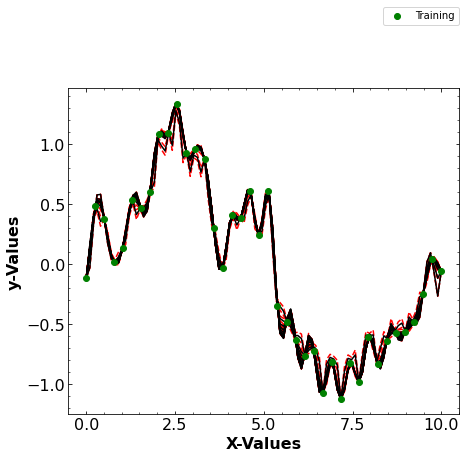

In [50]:
q1 = pm + norm.ppf(0.05, loc=0, scale=psd)
q2 = pm + norm.ppf(0.95, loc=0, scale=psd)
ytrue2 = np.sin((np.pi*xx/5)) + 0.2*np.cos(4*np.pi*xx/5)

# #Plot Posterior distribution
plt.figure(figsize = (7,6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(direction="in",top=True, right=True)
plt.locator_params(axis='y', nbins=7)
plt.locator_params(axis='x', nbins=5)
plt.minorticks_on() # turn on minor ticks
plt.tick_params(which="minor",direction="in",top=True, right=True)
plt.plot(xx, q1[0:10].T,  linestyle='dashed', color = "red")
plt.plot(xx, q2[0:10].T,  linestyle='dashed', color = "red")
plt.plot(xx, pm[0:10].T, color = "black")
plt.scatter(X, y, marker = "o", color = "green", label = "Training", zorder=3)

#Set plot details
plt.legend(fontsize=10,bbox_to_anchor=(0, 1.05, 1, 0.2),borderaxespad=0)
x_label = "X-Values"
y_label = "y-Values"
plt.xlabel(x_label, fontsize=16, fontweight='bold')
plt.ylabel(y_label, fontsize=16, fontweight='bold')
plt.show()

In [51]:
ell =10
n =100
X = np.linspace(0,10,n)
omega = np.linspace(-1,11, ell)
K = np.zeros((n,ell))
for j in range(ell):
    K[:,j] = scipy.stats.norm.pdf(X,  omega[j])
Beta = np.random.normal(size =(ell,3))
F = K@Beta

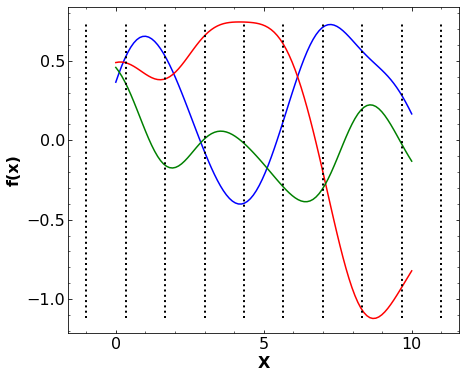

In [52]:
# #Plot Posterior distribution
plt.figure(figsize = (7,6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(direction="in",top=True, right=True)
plt.locator_params(axis='y', nbins=7)
plt.locator_params(axis='x', nbins=5)
plt.minorticks_on() # turn on minor ticks
plt.tick_params(which="minor",direction="in",top=True, right=True)
plt.plot(X,F[:,0], color = "blue")
plt.plot(X,F[:,1], color = "red")
plt.plot(X,F[:,2], color = "green")
plt.vlines(x=omega, ymin=np.min(F), ymax=np.max(F), colors='black', ls=':', lw=2, label='vline_single - full height')

#Set plot details
# plt.legend(fontsize=10,bbox_to_anchor=(0, 1.05, 1, 0.2),borderaxespad=0)
x_label = "X"
y_label = "f(x)"
plt.xlabel(x_label, fontsize=16, fontweight='bold')
plt.ylabel(y_label, fontsize=16, fontweight='bold')
plt.show()

In [53]:
x = np.linspace(0,10,40)
n =len(x)
K = np.zeros((n,ell))
for j in range(ell):
    K[:,j] = scipy.stats.norm.pdf(x,  omega[j])
print(K.shape)
K_df = pd.DataFrame(data = K)
# print(K_df)

(40, 10)


In [54]:
#Fit linear regression model given K and y
model = LinearRegression(fit_intercept=False).fit(K_df, y)

# print the coefficients
print(model.coef_)

[[ 2.88532063 -1.8266209   2.02754664  1.3236899   0.21531562  0.33685917
  -2.81146873  0.22241003 -1.86960153  3.25505778]]


In [55]:
xx = np.linspace(-1,11,100)
KK = np.zeros((len(xx),ell))
for j in range(ell):
    KK[:,j] = scipy.stats.norm.pdf(xx,  omega[j])
KK_df = pd.DataFrame(data = KK)

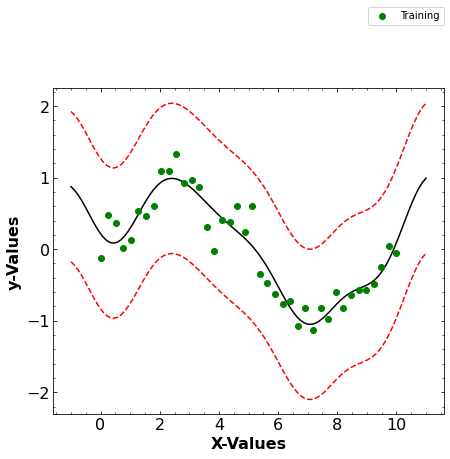

In [56]:
p = model.predict(KK)
stdev = np.std(p)
q1 = p + norm.ppf(0.05, loc=0, scale=stdev)
q2 = p + norm.ppf(0.95, loc=0, scale=stdev)
ytrue2 = np.sin((np.pi*xx/5)) + 0.2*np.cos(4*np.pi*xx/5)

# #Plot Posterior distribution
plt.figure(figsize = (7,6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(direction="in",top=True, right=True)
plt.locator_params(axis='y', nbins=7)
plt.locator_params(axis='x', nbins=7)
plt.minorticks_on() # turn on minor ticks
plt.tick_params(which="minor",direction="in",top=True, right=True)
plt.plot(xx, q1,  linestyle='dashed', color = "red")
plt.plot(xx, q2,  linestyle='dashed', color = "red")
plt.plot(xx, p, color = "black")
plt.scatter(x, y, marker = "o", color = "green", label = "Training", zorder=3)

#Set plot details
plt.legend(fontsize=10,bbox_to_anchor=(0, 1.05, 1, 0.2),borderaxespad=0)
x_label = "X-Values"
y_label = "y-Values"
plt.xlabel(x_label, fontsize=16, fontweight='bold')
plt.ylabel(y_label, fontsize=16, fontweight='bold')
plt.show()

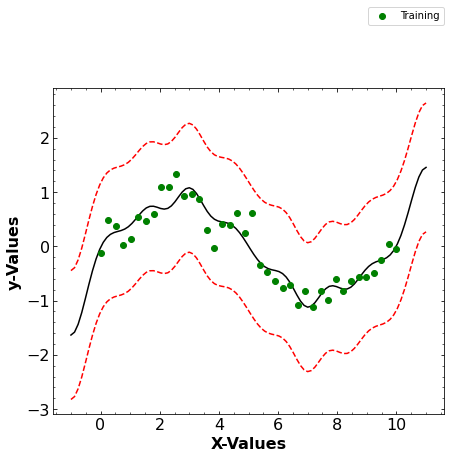

In [57]:
x = np.linspace(0,10,40)
n =len(x)
K = np.zeros((n,ell))
for j in range(ell):
    K[:,j] = scipy.stats.norm.pdf(x,  omega[j], 0.5)
K_df = pd.DataFrame(data = K)

#Fit linear regression model given K and y
model = LinearRegression(fit_intercept=False).fit(K_df, y)
# print the coefficients
# print(model.coef_)

xx = np.linspace(-1,11,100)
KK = np.zeros((len(xx),ell))
for j in range(ell):
    KK[:,j] = scipy.stats.norm.pdf(xx,  omega[j], 0.5)
KK_df = pd.DataFrame(data = KK)

p = model.predict(KK)
stdev = np.std(p)
q1 = p + norm.ppf(0.05, loc=0, scale=stdev)
q2 = p + norm.ppf(0.95, loc=0, scale=stdev)
ytrue2 = np.sin((np.pi*xx/5)) + 0.2*np.cos(4*np.pi*xx/5)

# #Plot Posterior distribution
plt.figure(figsize = (7,6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(direction="in",top=True, right=True)
plt.locator_params(axis='y', nbins=7)
plt.locator_params(axis='x', nbins=7)
plt.minorticks_on() # turn on minor ticks
plt.tick_params(which="minor",direction="in",top=True, right=True)
plt.plot(xx, q1,  linestyle='dashed', color = "red")
plt.plot(xx, q2,  linestyle='dashed', color = "red")
plt.plot(xx, p, color = "black")
plt.scatter(x, y, marker = "o", color = "green", label = "Training", zorder=3)

#Set plot details
plt.legend(fontsize=10,bbox_to_anchor=(0, 1.05, 1, 0.2),borderaxespad=0)
x_label = "X-Values"
y_label = "y-Values"
plt.xlabel(x_label, fontsize=16, fontweight='bold')
plt.ylabel(y_label, fontsize=16, fontweight='bold')
plt.show()

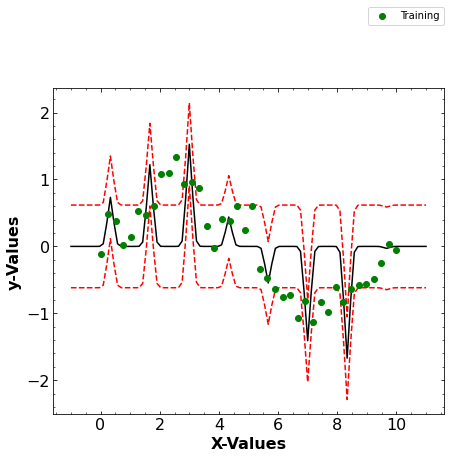

In [58]:
x = np.linspace(0,10,40)
n =len(x)
K = np.zeros((n,ell))
for j in range(ell):
    K[:,j] = scipy.stats.norm.pdf(x,  omega[j], 0.1)
K_df = pd.DataFrame(data = K)

#Fit linear regression model given K and y
model = LinearRegression(fit_intercept=False).fit(K_df, y)
# print the coefficients
# print(model.coef_)

xx = np.linspace(-1,11,100)
KK = np.zeros((len(xx),ell))
for j in range(ell):
    KK[:,j] = scipy.stats.norm.pdf(xx,  omega[j], 0.1)
KK_df = pd.DataFrame(data = KK)

p = model.predict(KK)
stdev = np.std(p)
q1 = p + norm.ppf(0.05, loc=0, scale=stdev)
q2 = p + norm.ppf(0.95, loc=0, scale=stdev)
ytrue2 = np.sin((np.pi*xx/5)) + 0.2*np.cos(4*np.pi*xx/5)

# #Plot Posterior distribution
plt.figure(figsize = (7,6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(direction="in",top=True, right=True)
plt.locator_params(axis='y', nbins=7)
plt.locator_params(axis='x', nbins=7)
plt.minorticks_on() # turn on minor ticks
plt.tick_params(which="minor",direction="in",top=True, right=True)
plt.plot(xx, q1,  linestyle='dashed', color = "red")
plt.plot(xx, q2,  linestyle='dashed', color = "red")
plt.plot(xx, p, color = "black")
plt.scatter(x, y, marker = "o", color = "green", label = "Training", zorder=3)

#Set plot details
plt.legend(fontsize=10,bbox_to_anchor=(0, 1.05, 1, 0.2),borderaxespad=0)
x_label = "X-Values"
y_label = "y-Values"
plt.xlabel(x_label, fontsize=16, fontweight='bold')
plt.ylabel(y_label, fontsize=16, fontweight='bold')
plt.show()

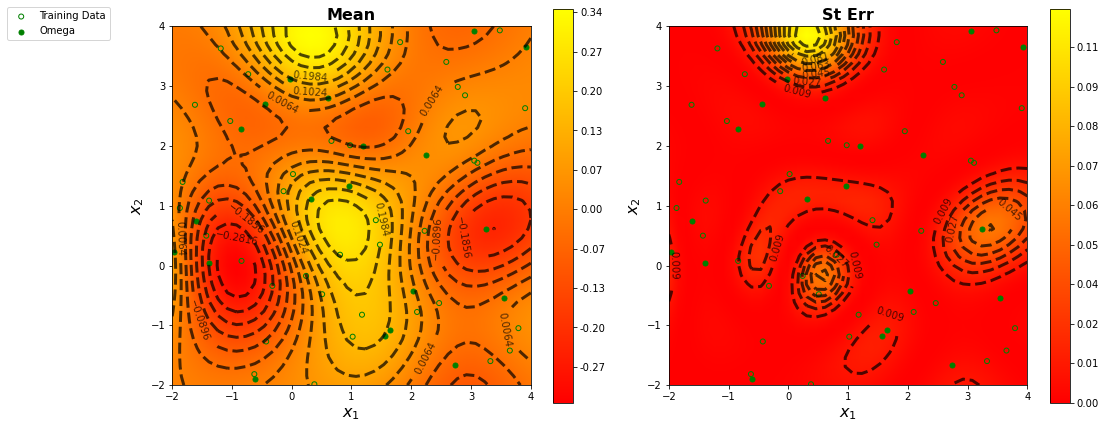

In [59]:
#Set number of experimental data/ set rng
np.random.seed(10) #Set seed
rng = np.random.default_rng() # sets up a "random" number generator
ndim= 2
nsamples = 40
gn =40

#Generate X data from LHS
X = LHS_Design(nsamples, ndim, seed = 10)
#Modify X data to correct scale
X[:,0] = (X[:,0] - 0.5)*6 +1
X[:,1] = (X[:,1] - 0.5)*6 +1

#Generate omega data
ell =20
omega = LHS_Design(ell, 2, seed = 10)
omega[:,0] = (omega[:,0] - 0.5)*6 +1
omega[:,1] = (omega[:,1] - 0.5)*6 +1

#Generate y data
y = X[:,0]*np.exp(-X[:,0]**2 -X[:,1]**2)

#Generate K matrix
n = len(X)
K = np.zeros((n,ell))
for j in range(ell):
    K[:,j] = scipy.stats.norm.pdf(X[:,0],  omega[j,0])*scipy.stats.norm.pdf(X[:,1],  omega[j,1])
# print(K.shape)
K_df = pd.DataFrame(data = K)

#Fit model
#Fit linear regression model given K and y
model = LinearRegression(fit_intercept=False).fit(K_df, y)

xx = np.linspace(-2,4,gn)
XX_mesh = np.array(np.meshgrid(xx,xx))
XX = XX_mesh.reshape((2,gn**2)).T
yy = XX[:,0]*np.exp(-XX[:,0]**2 -XX[:,1]**2)
# print(XX.shape)

#Define KK
KK = np.zeros((len(XX),ell))
for j in range(ell):
    KK[:,j] = scipy.stats.norm.pdf(XX[:,0], omega[j,0])*scipy.stats.norm.pdf(XX[:,1],  omega[j,1])
KK_df = pd.DataFrame(data = KK)
p = model.predict(KK)

#Calculate error
std_err = (yy - p)**2
# beta_hat = np.linalg.inv(KK.T @ KK) @ KK.T @ yy
# y_hat = model.predict(KK)
# residuals = yy - y_hat
# residual_sum_of_squares = residuals.T @ residuals
# sigma_squared_hat = residual_sum_of_squares / (n - ndim)
# var_beta_hat = np.linalg.inv(KK.T @ KK) * sigma_squared_hat
# for dim_ in range(ndim):
#     standard_error = var_beta_hat[dim_, dim_] ** 0.5

# #Plot
X1, X2 = XX_mesh
Z1 = p.reshape(gn,gn)
Z2 = std_err.reshape(gn,gn)
z = [Z1,Z2]
tot_lev = [60,60]
#Set plot details for mean predictions
fig, axes = plt.subplots(nrows = 1, ncols = len(z), figsize = (14,6))
ax = axes
title = ["Mean", "St Err"]

for i in range(len(z)):      
    #Create a colormap and colorbar for each subplot
    cs_fig = ax[i].contourf(X1, X2,z[i], levels = 900, cmap = "autumn")
    if np.amax(z[i]) < 1e-1 or np.amax(z[i]) > 1000:
        cbar = plt.colorbar(cs_fig, ax = ax[i], format='%.2e')
    else:
        cbar = plt.colorbar(cs_fig, ax = ax[i], format = '%2.2f')

    #Create a line contour for each colormap
    cs2_fig = ax[i].contour(cs_fig, levels=cs_fig.levels[::tot_lev[i]], colors='k', alpha=0.7, linestyles='dashed', linewidths=3)
    ax[i].clabel(cs2_fig,  levels=cs_fig.levels[::tot_lev[i]][1::2], fontsize=10, inline=1)

    #plot training data X values
    ax[i].scatter(X[:,0],X[:,1], color="green",s=25, label = "Training Data", marker = "o", facecolors='none')  
    ax[i].scatter(omega[:,0],omega[:,1], color="green",s=25, label = "Omega", marker = "o")

    #Get legend information
    if i == len(z)-1:
        handles, labels = ax[i].get_legend_handles_labels()

    #Plots axes such that they are scaled the same way (eg. circles look like circles) and name axes
    ax[i].axis('scaled')  
    ax[i].set_xlabel('$x_1$',weight='bold',fontsize=16)
    ax[i].set_ylabel('$x_2$',weight='bold',fontsize=16)

    #Plot title and set axis scale
    ax[i].set_title(title[i], weight='bold',fontsize=16)
    ax[i].set_xlim(left = np.amin(X1), right = np.amax(X1))
    ax[i].set_ylim(bottom = np.amin(X2), top = np.amax(X2))      

#Plots legend and title
plt.tight_layout()
fig.legend(handles, labels, loc="lower right", bbox_to_anchor=(-0.01, 0.9), borderaxespad=0)  #bbox_to_anchor=(-0.01, 0.9), borderaxespad=0
plt.show()

## 5.4.2 Limits of Stantionarity

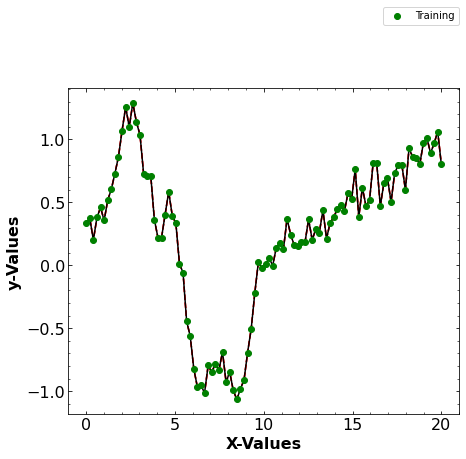

In [60]:
X = np.linspace(0,20,100).reshape(-1,1)
XX = np.linspace(0,20,500).reshape(-1,1)
y =  np.sin((np.pi*X/5)) + 0.2*np.cos(4*np.pi*X/5) *(X<=9.6).reshape(-1,1)
lin = X>9.6
y[lin] = -1 + X[lin]/10
y = y + np.random.normal(size=(len(y))  ,loc = 0, scale = 0.1).reshape(-1,1)

kernel = ConstantKernel(constant_value=0.1*np.var(y))*RBF(length_scale = 0.1)
gpr = GaussianProcessRegressor(kernel=kernel, random_state=10, n_restarts_optimizer =1)
fit_process = gpr.fit(X, y)
results = gpr.predict(X, return_std=True)
ll = gpr.log_marginal_likelihood()
pm = results[0]
psd = results[1]

q1 = pm + norm.ppf(0.05, loc=0, scale=psd)
q2 = pm + norm.ppf(0.95, loc=0, scale=psd)

# #Plot Posterior distribution
plt.figure(figsize = (7,6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(direction="in",top=True, right=True)
plt.locator_params(axis='y', nbins=7)
plt.locator_params(axis='x', nbins=7)
plt.minorticks_on() # turn on minor ticks
plt.tick_params(which="minor",direction="in",top=True, right=True)
plt.plot(X, q1,  linestyle='dashed', color = "red")
plt.plot(X, q2,  linestyle='dashed', color = "red")
plt.plot(X, pm, color = "black")
plt.scatter(X, y, marker = "o", color = "green", label = "Training", zorder=3)

#Set plot details
plt.legend(fontsize=10,bbox_to_anchor=(0, 1.05, 1, 0.2),borderaxespad=0)
x_label = "X-Values"
y_label = "y-Values"
plt.xlabel(x_label, fontsize=16, fontweight='bold')
plt.ylabel(y_label, fontsize=16, fontweight='bold')
plt.show()

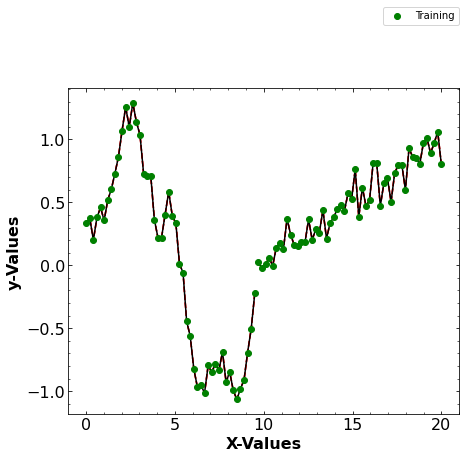

In [61]:
left = X<9.6
right = X>9.6
kernel_l = ConstantKernel(constant_value=0.1*np.var(y))*RBF(length_scale = 0.1)
gpr_l = GaussianProcessRegressor(kernel=kernel_l, random_state=10, n_restarts_optimizer =1)
fit_process_l = gpr_l.fit(X[left].reshape(-1,1), y[left].reshape(-1,1))

kernel_r = ConstantKernel(constant_value=0.1*np.var(y))*RBF(length_scale = 0.1)
gpr_r = GaussianProcessRegressor(kernel=kernel_r, random_state=10, n_restarts_optimizer =1)
fit_process_r = gpr_r.fit(X[right].reshape(-1,1), y[right].reshape(-1,1))

results_l = gpr_l.predict(X[left].reshape(-1,1), return_std=True)
results_r = gpr_r.predict(X[right].reshape(-1,1), return_std=True)

pm_l = results_l[0]
pm_r = results_r[0]
psd_l = results_l[1]
psd_r = results_r[1]

q1_l = pm_l + norm.ppf(0.05, loc=0, scale=psd_l)
q2_l = pm_l + norm.ppf(0.95, loc=0, scale=psd_l)

q1_r = pm_r + norm.ppf(0.05, loc=0, scale=psd_r)
q2_r = pm_r + norm.ppf(0.95, loc=0, scale=psd_r)

# #Plot Posterior distribution
plt.figure(figsize = (7,6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(direction="in",top=True, right=True)
plt.locator_params(axis='y', nbins=7)
plt.locator_params(axis='x', nbins=7)
plt.minorticks_on() # turn on minor ticks
plt.tick_params(which="minor",direction="in",top=True, right=True)
plt.plot(X[left], q1_l,  linestyle='dashed', color = "red")
plt.plot(X[left], q2_l,  linestyle='dashed', color = "red")
plt.plot(X[right], q1_r,  linestyle='dashed', color = "red")
plt.plot(X[right], q2_r,  linestyle='dashed', color = "red")
plt.plot(X[left], pm_l, color = "black")
plt.plot(X[right], pm_r, color = "black")
plt.scatter(X, y, marker = "o", color = "green", label = "Training", zorder=3)

#Set plot details
plt.legend(fontsize=10,bbox_to_anchor=(0, 1.05, 1, 0.2),borderaxespad=0)
x_label = "X-Values"
y_label = "y-Values"
plt.xlabel(x_label, fontsize=16, fontweight='bold')
plt.ylabel(y_label, fontsize=16, fontweight='bold')
plt.show()